Modeling: Multiple Linear Regression, Support Vector Machine, Neural Network

In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import datetime
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in data: 
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
X_train.index = X_train['Time']
X_train = X_train.drop(['Time'], axis=1)
X_test.index = X_test['Time']
X_test = X_test.drop(['Time'], axis=1)
y_train.index = y_train['Time']
y_train = y_train.drop(['Time'], axis=1)
y_test.index = y_test['Time']
y_test = y_test.drop(['Time'], axis=1)

In [3]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)             
rfe = rfe.fit(X_train, y_train)

# predict counts of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.45634755228780666


In [4]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict count of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print("R-squared: ", r2)

# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
print("R-squared: ", scores)

# Tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print("neg_mean_squared_error: ", scores)

R-squared:  0.44978387926349406
R-squared:  [0.41956621 0.44684042 0.46984199 0.45928324 0.44893947]
neg_mean_squared_error:  [-0.56333458 -0.54566715 -0.55325863 -0.54882852 -0.54091382]


Number of features:  12
Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    1.1s finished


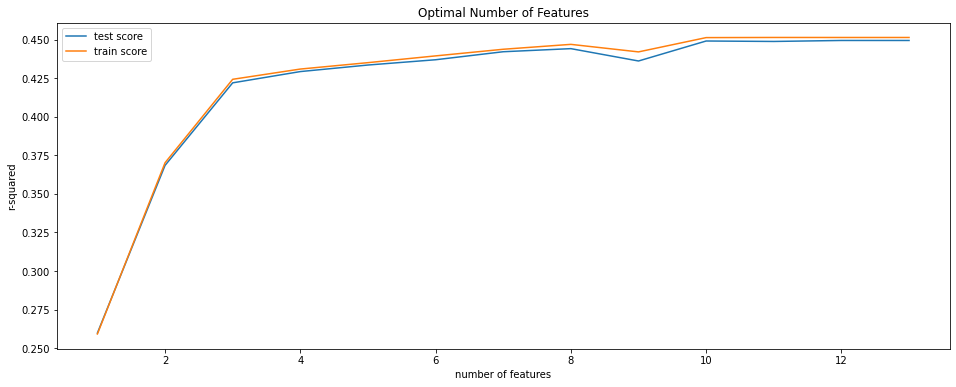

In [5]:
# Hyperparameter Tuning Using Grid Search Cross-Validation
# number of features in X_train
print("Number of features: ", len(X_train.columns))

# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train) 

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

# plotting cv results
plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left');

In [6]:
# final model for Multiple Linear Regression
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict counts of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.45627572593755406


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


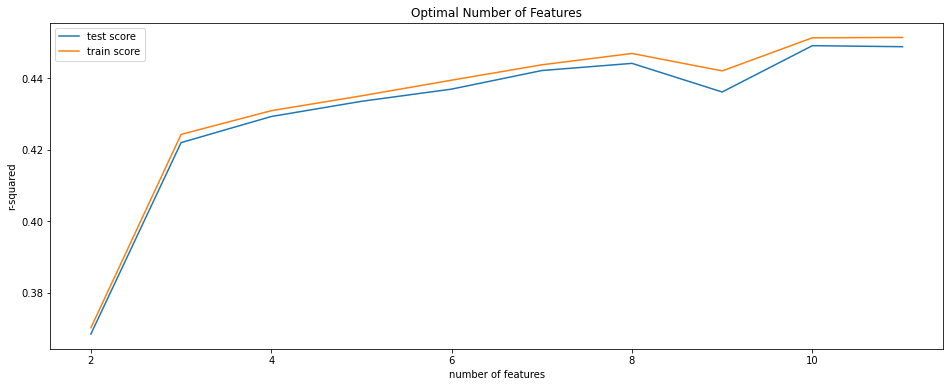

In [7]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 12))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left');

In [8]:
# Support Vector Machine Regression
from sklearn.svm import SVR

X = X_train
y = y_train

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [9]:
svr_lin = SVR(kernel='linear', C=1e3)

In [10]:
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

In [11]:
y_rbf = svr_rbf.fit(X, y).predict(X) #Takes a minute or two

In [11]:
y_lin = svr_lin.fit(X, y).predict(X) #Takes 20 minutes

In [12]:
y_poly = svr_poly.fit(X, y).predict(X)

In [13]:
#from sklearn.grid_search import GridSearchCV
#param_grid = {'svc__C': [1, 5, 10, 50],
             # 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
#grid = GridSearchCV(model, param_grid)

#%time grid.fit(X_train, y_train)
#print(grid.best_params_)

from sklearn.svm import SVR
from sklearn.model_selection import learning_curve, GridSearchCV
#from sklearn.model_selection import GridSearchCV
#param_grid = { 'C':[0.1,1,100,1000],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6],'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
param_grid = { 'C':[0.1, 10, 100],'kernel':['rbf'],'gamma': [1, 0.1, 0.01], 'epsilon': [0.1]}
grid = GridSearchCV(SVR(),param_grid)
grid.fit(X_train,y_train)

#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

{'C': 100, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.6442258793336829


In [14]:
print(grid.best_params_)

print(grid.score(X_test,y_test))

{'C': 100, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.6442258793336829


In [15]:
# predict counts of X_test
y_pred = grid.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.6442258793336829


Neural Network Model

In [20]:
# Neural networks model
import sys
sys.path.append('/Users/elinorvelasquez/anaconda3/lib/python3.8/site-packages/')
#!conda install -c conda-forge statsmodels

import sklearn
import nltk

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
# For neural networks, > 0.18 is needed. I have 0.23.2.

The nltk version is 3.6.1.
The scikit-learn version is 0.23.2.


In [21]:
# The neural network in Python may have difficulty converging before the maximum number of iterations allowed 
# if the data is not normalized. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
# Now apply the transformations to the data:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=50)
#y_train1 = y_train.drop(['Time'], axis=1)
y_train1 = y_train.astype('int')

mlp.fit(X_train, np.ravel(y_train1))
predictions = mlp.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
#y_test1 = y_test.drop(['Time'], axis=1)
y_test1 = y_test.astype('int')

print(confusion_matrix(y_test1, predictions))
print(classification_report(y_test1, predictions))
print(len(mlp.coefs_))
print(len(mlp.coefs_[0]))
print(len(mlp.intercepts_[0]))

[[  98   50    0    0    0    0]
 [  23 1277    9    3    0    0]
 [   0  169   24    5    0    0]
 [   0   55   15   13    0    0]
 [   0    3    2    3    0    0]
 [   0    0    1    2    0    0]]
              precision    recall  f1-score   support

          -1       0.81      0.66      0.73       148
           0       0.82      0.97      0.89      1312
           1       0.47      0.12      0.19       198
           2       0.50      0.16      0.24        83
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         3

    accuracy                           0.81      1752
   macro avg       0.43      0.32      0.34      1752
weighted avg       0.76      0.81      0.76      1752

4
12
13
